# Classify images using pretrained ResNet50v2 with Fine tuning and data augmentation

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        # ...
        #/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/2f2e95f3a.png
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Inspect data

In [72]:
import csv

# Create a CSV with images names
csv_trainfile="/kaggle/working/train.csv"

with open(csv_trainfile, 'w') as file:
    for dirname, _, filenames in os.walk('/kaggle/input/plant-seedlings-classification/train'):
        for filename in filenames:
            class_name = dirname
            class_name = class_name.replace('/kaggle/input/plant-seedlings-classification/train/', "")
            row = dirname + "/" + filename + ";" + class_name + ";" + filename
            file.write(row + '\n')

In [86]:
# Inspect Data
column_names=['path','specie','file']
dataFrameTrain = pd.read_csv(csv_trainfile, delimiter=';', header=None)
dataFrameTrain.columns = column_names

print(dataFrameTrain.shape)
print(dataFrameTrain.head())

(4750, 3)
                                                path             specie  \
0  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed   
1  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed   
2  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed   
3  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed   
4  /kaggle/input/plant-seedlings-classification/t...  Scentless Mayweed   

            file  
0  4ae939d7d.png  
1  b8664f705.png  
2  628b08c82.png  
3  9ab3b61db.png  
4  086894274.png  


In [87]:
print(dataFrameTrain.describe()) # Verify there are no NaNs

                                                     path            specie  \
count                                                4750              4750   
unique                                               4750                12   
top     /kaggle/input/plant-seedlings-classification/t...  Loose Silky-bent   
freq                                                    1               654   

                 file  
count            4750  
unique           4750  
top     4ae939d7d.png  
freq                1  


In [88]:
# Distribution per classes
classes = dataFrameTrain['specie'].unique()
print(f"Number of classes: {len(classes)}")

datos_classes = dataFrameTrain.groupby('specie').count()
print(datos_classes)

Number of classes: 12
                           path  file
specie                               
Black-grass                 263   263
Charlock                    390   390
Cleavers                    287   287
Common Chickweed            611   611
Common wheat                221   221
Fat Hen                     475   475
Loose Silky-bent            654   654
Maize                       221   221
Scentless Mayweed           516   516
Shepherds Purse             231   231
Small-flowered Cranesbill   496   496
Sugar beet                  385   385


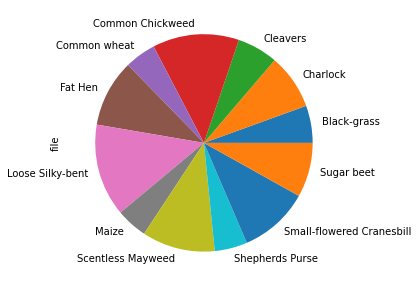

In [89]:
plot = datos_classes.plot.pie(y='file', figsize=(5, 5), legend=False)

We have 4750 samples to use for test and validation. Classes are not balanced. 

<Figure size 432x288 with 0 Axes>

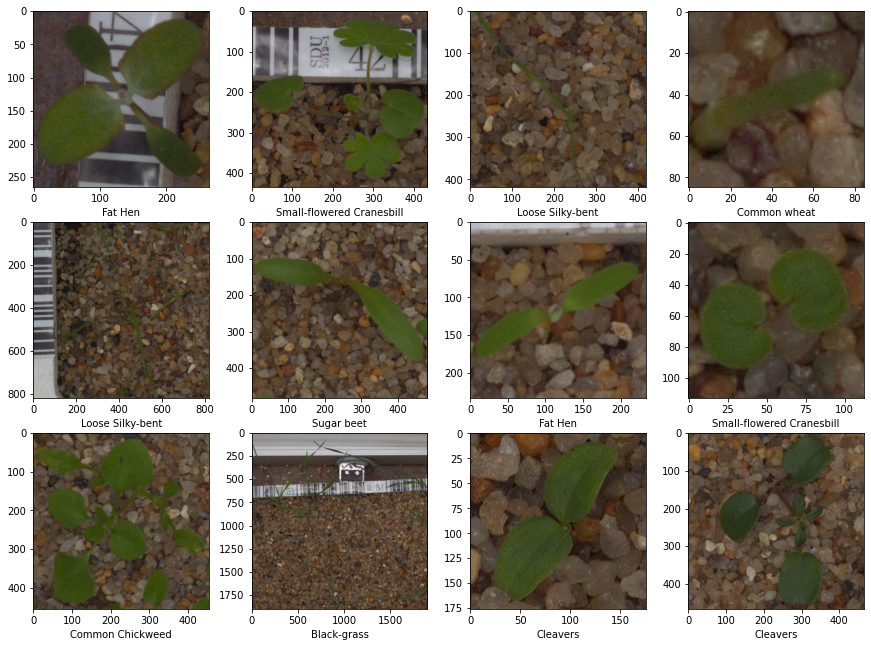

Image Shape:  (466, 466, 3)
Pixel value:  [85 59 37]


In [99]:
import random

# Analize images
from skimage import io
import matplotlib.pyplot as plt

fig = plt.figure()
plt.figure(figsize=(15,11))

for i in range(12):
    plt.subplot(3, 4, i+1)
    num = random.randint(0,len(dataFrameTrain))
    file = dataFrameTrain['path'][num]
    img = io.imread(file)
    plt.imshow(img)
    plt.xlabel(dataFrameTrain['specie'][num])
plt.show()

print("Image Shape: ", img.shape)
print("Pixel value: ", img[0][0])

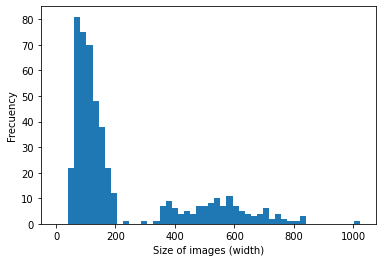

In [96]:
width = []

for file_num in range(500):
    path = dataFrameTrain['path'][file_num]
    img = io.imread(path)
    width.append(img.shape[0])

plt.hist(width, bins=50, range=(0,1024)) 
plt.xlabel('Size of images (width)')
plt.ylabel('Frecuency')
plt.show()

Images are RGB and pixels can go from 0 to 255. Also, they are quite different in background, sharpness etc

Images have different sizes

## 2. Prepare data

In [101]:
# Import the necessary packages
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.callbacks import ModelCheckpoint
from math import exp
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input


In [110]:
file = '/kaggle/working/pretrained_ResNet50V2_vFINAL'
batch_size = 32
seed = 42
val_split = 0.2
image_size = (256,256)
PROYECT_FOLDER_TRAIN = '/kaggle/input/plant-seedlings-classification/train/'

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input, # Standandardize for Resnet
    rotation_range = 30, # Int. Degree range for random rotations.
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.7,1.3],
    rescale = 0.9,
    vertical_flip = True,
    horizontal_flip = True,
    validation_split=val_split)

val_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input, 
    validation_split=val_split)

train_generator = train_datagen.flow_from_directory(
    PROYECT_FOLDER_TRAIN, # It should contain one subdirectory per class. 
    target_size = image_size, # Dims to which all images found will be resized.
    color_mode = 'rgb',
    batch_size = batch_size,
    class_mode = "categorical", # Type of label arrays that are returned
    subset='training',
    seed=seed,
    shuffle=True
    )

val_generator = val_datagen.flow_from_directory(
    PROYECT_FOLDER_TRAIN, 
    target_size = image_size, 
    color_mode = 'rgb',
    batch_size=batch_size, 
    class_mode = "categorical",
    subset='validation',
    seed=seed,
    shuffle=True
    )


Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


We have split train dataset (4750 samples) in:

* 80% train: 3803 samples
* 20% validation: 947 samples

## 3. Write neural network architecture and train

In [112]:
input_shape_c = tuple((image_size[0], image_size[1], 3))
print(input_shape_c)

base_model = ResNet50V2(
    weights='imagenet',
    include_top=False, 
    input_shape=input_shape_c) # It should have exactly 3 inputs channels, and width and height should be no smaller than 32.

# base_model.summary()

(256, 256, 3)


In [113]:
# We freeze layers in first 4 convolutional blocks. Fifth will be re trained
for layer in base_model.layers: 
    if layer.name == 'conv5_block1_1_conv': 
        break 
    layer.trainable = False 

# We add more layers to complete the classification part
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())

pre_trained_model.add(layers.Dense(512, activation='relu'))

pre_trained_model.add(Dropout(0.5))
pre_trained_model.add(BatchNormalization())

pre_trained_model.add(layers.Dense(12, activation='softmax'))
pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                6156      
Total params: 90,682,380
Trainable params: 82,085,388
Non-trainable params: 8,596,992
____________________________________

In [114]:
# We compile the model
# Compilar el modelo
epochs = 200

print("[INFO]: Compiling the model...")
pre_trained_model.compile(loss="categorical_crossentropy", 
                          optimizer=Adam(learning_rate=1e-3), 
                          metrics=["accuracy"]) 

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * exp(-0.1)

annealer = LearningRateScheduler(scheduler)

earlystop = EarlyStopping(
    patience=5,
    monitor="val_loss",
    )

modelsave = ModelCheckpoint(
    filepath = file + '.h5', 
    save_best_only = True, 
    verbose = 1)

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(train_generator, 
                              validation_data = val_generator, 
                              steps_per_epoch = train_generator.n//train_generator.batch_size,
                              validation_steps = val_generator.n//val_generator.batch_size,
                              epochs=epochs,
                              callbacks=[annealer, earlystop, modelsave]
                              )

[INFO]: Compiling the model...
[INFO]: Entrenando la red...


2022-12-11 11:38:56.672840: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-12-11 11:39:02.239935: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


118/118 [==============================] - 181s 1s/step - loss: 1.0512 - accuracy: 0.6653 - val_loss: 1.6707 - val_accuracy: 0.6983

Epoch 00001: val_loss improved from inf to 1.67069, saving model to /kaggle/working/pretrained_ResNet50V2_vFINAL.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
118/118 [==============================] - 109s 926ms/step - loss: 0.4994 - accuracy: 0.8295 - val_loss: 0.5260 - val_accuracy: 0.8739

Epoch 00002: val_loss improved from 1.67069 to 0.52598, saving model to /kaggle/working/pretrained_ResNet50V2_vFINAL.h5
Epoch 3/200
118/118 [==============================] - 107s 909ms/step - loss: 0.4294 - accuracy: 0.8589 - val_loss: 0.5729 - val_accuracy: 0.8287

Epoch 00003: val_loss did not improve from 0.52598
Epoch 4/200
118/118 [==============================] - 117s 989ms/step - loss: 0.4042 - accuracy: 0.8613 - val_loss: 0.4669 - val_accuracy: 0.8588

Epoch 00004: val_loss improved from 0.52598 to 0.46690, saving model to /kaggle/working/pretrained_ResNet50V2_vFINAL.h5
Epoch 5/200
118/118 [==============================] - 110s 932ms/step - loss: 0.4541 - accuracy: 0.8518 - val_loss: 0.3294 - val_accuracy: 0.9019

Epoch 00005: val_loss improved from 0.46690 to 0.32943, saving model to /kaggle/working/pretrained_ResNet50V2_vFINAL.

## 4. Monitor Results

[INFO]: Evaluating the model...


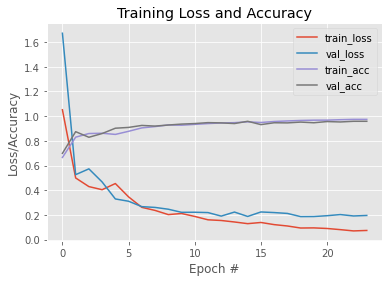

In [117]:
# Evaluating the model
print("[INFO]: Evaluating the model...")

num_epochs = len(H_pre.history["loss"])

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

This version here is the result of a long exercise to finetune parameters. It has been a challenge for different reasons:

* There were few samples to train: Only 4750 split in 12 clases (well, in reality only 80% of those were used to train)
* Classes were not equally balanced/present in the dataset
* Images have different sizes, backgrounds, sharpness...
* In ImageNet dataset, there are not many categories related to plants that we could directly inherit from

Architecture definition:
* After some analysis, it has proven to be positive to freeze last block and to add a Dense layer in the top model.

Train hyperparameters:
* Input images best resize has been proven to be (256,256). Even though 50% of images were smaller that this size, results were much better than using 32x32, 64x64 or 128x128.
* Best learning rate has been found in 1e-3 (with some decay). 

Also, we have tried to reduce overfitting:
* Adding Drop out and batch normalization in the top model
* Using data augmentation 

## 5. Predict Test Results

In [118]:
# Create a CSV with images names
csv_testfile="/kaggle/working/test.csv"

with open(csv_testfile, 'w') as file:
    for dirname, _, filenames in os.walk('/kaggle/input/plant-seedlings-classification/test'):
        for filename in filenames:
            row = dirname + "/" + filename + ";" + filename
            file.write(row + '\n')

In [122]:
# Inspect Data
column_names=['path','file']
dataFrameTest = pd.read_csv(csv_testfile, delimiter=';', header=None)
dataFrameTest.columns = column_names

print(dataFrameTest.shape)
print(dataFrameTest.head())
print(dataFrameTest['path'][0])

(794, 2)
                                                path           file
0  /kaggle/input/plant-seedlings-classification/t...  fd87b36ae.png
1  /kaggle/input/plant-seedlings-classification/t...  0e8492cb1.png
2  /kaggle/input/plant-seedlings-classification/t...  8d6acbe9b.png
3  /kaggle/input/plant-seedlings-classification/t...  54b3afd58.png
4  /kaggle/input/plant-seedlings-classification/t...  6049234e6.png
/kaggle/input/plant-seedlings-classification/test/fd87b36ae.png


In [202]:
# Prepare data
batch_size = 1
seed = 42
image_size = (256,256)
PROYECT_FOLDER_TEST = '/kaggle/input/plant-seedlings-classification/'

test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    PROYECT_FOLDER_TEST, 
    target_size = image_size, 
    color_mode = 'rgb',
    batch_size = batch_size, 
    classes = ['test'],
    shuffle = False
)

        


Found 794 images belonging to 1 classes.


In [220]:
list_of_files = test_generator.filenames
print(list_of_files[0])


test/0021e90e4.png


In [218]:
predicted_class = pre_trained_model.predict(test_generator)


In [219]:
# print(len(predicted_class[0]))
# print(len(predicted_class))
predicted_class_number = np.argmax(predicted_class, axis=1)
# print(len(predicted_class_number))

# flow_from_directory orders the classes alphabetically
classes = dataFrameTrain['specie'].unique()
classes.sort()
print(classes)

print(predicted_class_number)

['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
[10  5 11  3 11  0  3  5  6  6  5 10 11  8 11  5  8  8  3  9  3 10  9 11
 11  7  8  8  3 11  3  9  6  2  6  6  0  6  3  7  6  4  3 10 11 11  7  8
  7 10  6 11  2  6  7  5  1 10  2  6 11  2  1  4  7  5  0  6  9  8 10  3
  8  3  3  4  6  8  8  6 11  3  3  4  9 11  2  8  5  6  1  6  5  6  3  6
 10  8  7 10  5  5  8 11  5  5  3  8  2  2  6  1  3  9  9 11  2  1 11  3
  3 11  2  6  7  4  1  7  5  3 11 11  3  3  5  4  5  1  0  3  6 10  9  3
  5 11  4 10 11  1  8  6  7  8  6 10  3  5  6  2  1  6  8  8  9  6  8  4
  3  3  9  7  9  3  3 10  0  2  6  6  6 10  6  6  8  0  3  5  5 10  6  1
  8  4  1  6  4  3  6  3  2  6  1  1 10  2  5  3  5  9  5  1  5  6 10  2
  7  6 10  3  8  6  3 10  4  5  5  3  3  7  9  2  9  2  3  0  0  2 10  1
 11  3  7 10  2  9  6  5 10  5  3  6  7  3  3  4  2  1 10  3  6  7  3  7
 10  2 

In [221]:
csv_resultsfile="/kaggle/working/results.csv"

with open(csv_resultsfile, 'w') as file:
    row='file,species'
    file.write(row + '\n')
    for i in range(len(predicted_class_number)):
        file_name = list_of_files[i]
        file_name = file_name.replace('test/','') 
        class_name = classes[predicted_class_number[i]]
        row = file_name + "," + class_name
        file.write(row + '\n')

In [222]:
dataFrameResults = pd.read_csv(csv_resultsfile, delimiter=',')
print(dataFrameResults.shape)
print(dataFrameResults.head())

(794, 2)
            file                    species
0  0021e90e4.png  Small-flowered Cranesbill
1  003d61042.png                    Fat Hen
2  007b3da8b.png                 Sugar beet
3  0086a6340.png           Common Chickweed
4  00c47e980.png                 Sugar beet


Kaggle web page: https://www.kaggle.com/competitions/plant-seedlings-classification/overview

## Seeing the results for "train" images

In [199]:
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/plant-seedlings-classification/train/', 
    target_size = image_size, 
    color_mode = 'rgb',
    batch_size=batch_size, 
    classes=['Cleavers'],
    shuffle=False
    )


Found 287 images belonging to 1 classes.


In [200]:
predicted_class = pre_trained_model.predict(test_generator)

In [201]:
print(len(predicted_class[0]))
print(len(predicted_class))
predicted_class_number = np.argmax(predicted_class, axis=1)
print(len(predicted_class_number))

print(predicted_class_number)

12
287
287
[2 2 2 2 2 2 3 2 2 2 2 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
